In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import comb
from copy import deepcopy
import cv2
from scipy.ndimage import maximum_filter
import pywt


In [9]:
def open_image(img_path):
    img = cv2.imread(img_path)
    return img

def get_gray_img_mat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def expand_image(img, expanded_size, kernel_size=5, ratio=2):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / (weights / 4)
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0] * ratio:ratio, :img.shape[1] * ratio:ratio] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


# create a function that returns the gaussian kernel for a given size and the total sum of the kernel
# for example ofr size=5 return kernel = np.array([[1, 4, 6, 4, 1],
# [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) and weight = 256
def get_gaussian_kernel(size):
    # Calculate the kernel
    n = math.floor(size)
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = comb(n - 1, i) * comb(n - 1, j)

    # Normalize the kernel to make the sum an integer
    kernel_sum = np.sum(kernel)
    kernel_factor = int(np.ceil(kernel_sum))
    kernel = (kernel * kernel_factor / kernel_sum).astype(int)

    return kernel, kernel_factor


def reduce_image(img, reduced_img_size, kernel_size=5, should_blur=True):
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / weights
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))

    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]

    return reduced_img


def get_reduced_size(img, factor=2):
    return (img.shape[0] // factor, img.shape[1] // factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1]))) - 1


# @measure_time
def create_pyramid(img, kernel_size=5):
    pyramid = []
    pyramid.append({'G': img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size, kernel_size)
        expanded_image_size = pyramid[i - 1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size, kernel_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})

    for i in range(len(pyramid) - 1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i + 1]['Expanded_G']
    pyramid[-1]['L'] = pyramid[-1]['G']
    return pyramid


def get_mask_pyramid(mask):
    mask = np.ceil(mask / 255)
    mask_pyramid = []
    mask_pyramid.append({'G': mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid



In [131]:
# implementing Harris corner detection
def harris_corner_detection(gray_img, harris_window_size, k):
    img_gaussian = cv2.GaussianBlur(gray_img,(3,3),0)

    Ix = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy

    harris_window = np.ones((harris_window_size, harris_window_size))
    Sx2 = convolve2d(Ix2, harris_window, mode='same')
    Sy2 = convolve2d(Iy2, harris_window, mode='same')
    Sxy = convolve2d(Ixy, harris_window, mode='same')

    det = Sx2 * Sy2 - (Sxy ** 2)
    trace = Sx2 + Sy2

    R = det - k * (trace ** 2)
    cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX)    
    return R

# Suppress non-maximum responses
def non_maximum_suppression(corners, suppression_window_size):
    # Apply maximum filter for non-maximum suppression
    suppressed_corners = corners * (corners == maximum_filter(corners, footprint=np.ones((suppression_window_size, suppression_window_size))))
    return suppressed_corners


# create multiscale Harris corner detector
def multiscale_harris_corner_detector(pyramid, scales, harris_window_size, k, suppression_window_size):
    # Initialize corners tensor
    corners_arr = np.zeros((scales,), dtype=np.ndarray)
    # Iterate over the scales in the pyramid 
    for scale in range(scales):
        # Perform the Harris corner detection
        corners = harris_corner_detection(pyramid[scale]['G'], harris_window_size, k)     
        # Add the corners to the corners tensor
        if suppression_window_size:
            corners = non_maximum_suppression(corners, suppression_window_size)
        corners_arr[scale] = corners
    return corners_arr


# create a function the iterates over the matches for each descriptor adds its real coordinates in the 0 scale 
# and the coordinates of the match in the 0 scale
def get_matches_with_original_coordinates(matches):
    matches_with_original_coordinates = []
    for match in matches:
        x, y, scale, theta, descriptor = match[0]
        x_original, y_original = get_original_coordinates(match[0])
        x_prime, y_prime, scale_prime, theta_prime, descriptor_prime = match[1]
        x_prime_original, y_prime_original = get_original_coordinates(match[1])
        matches_with_original_coordinates.append([(x_original, y_original, scale, theta, descriptor), (x_prime_original, y_prime_original, scale_prime, theta_prime, descriptor_prime)])        
    return matches_with_original_coordinates

# implement RANSAC algorithm - each iteration, randomly select 4 matches and calculate the homography matrix
# then, calculate the number of inliers for each match and select the best homography matrix
# finally, return the best homography matrix
def ransac(matches_with_original_coordinates, iterations, threshold):
    best_homography = None
    best_inliers = 0
    best_inliers_matches = []
    for iter in range(iterations):
        # Randomly select 4 indexes from the matches
        random_indexes = np.random.choice(len(matches_with_original_coordinates), 4, replace=False)
        random_matches = [matches_with_original_coordinates[i] for i in random_indexes]
        # Calculate the homography matrix
        H = calculate_homography(random_matches)
        # Calculate the number of inliers
        inliers = 0
        inliers_matches = []
        
        for match in matches_with_original_coordinates:
            # Apply the transformation to the point
            p = np.array([match[0][0], match[0][1], 1])
            p_prime = np.dot(H, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Calculate the distance between the transformed point and the second point
            distance = np.linalg.norm(p_prime - np.array([match[1][0], match[1][1]]))
            # If the distance is less than the threshold, increment the number of inliers
            if distance < threshold:
                inliers += 1
                inliers_matches.append(match)
        # If the current homography matrix has more inliers than the best one, update the best one
        if inliers > best_inliers:
            best_inliers = inliers
            best_inliers_matches = inliers_matches
            best_homography = H
        if iter % 100 == 0:
            print(f'iteration {iter}, best inliers: {best_inliers}')
    return best_homography, best_inliers_matches


        
# function for calculating the homography matrix without using cv2.findHomography
def calculate_homography(matches):
    src_pts = np.array([[match[0][0], match[0][1]] for match in matches])
    dst_pts = np.array([[match[1][0], match[1][1]] for match in matches])
    A = []
    for i in range(len(matches)):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([x, y, 1, 0, 0, 0, -x_prime * x, -x_prime * y, -x_prime])
        A.append([0, 0, 0, x, y, 1, -y_prime * x, -y_prime * y, -y_prime])
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H


# create a function that based on the scale of a descriptor, returns the original coordinates of the descriptor
def get_original_coordinates(descriptor):
    return descriptor[0] * (2 ** descriptor[2]), descriptor[1] * (2 ** descriptor[2])


# create a function that returns the euclidean distance between two descriptors
def euclidean_distance(descriptor1, descriptor2):
    return np.linalg.norm(descriptor1 - descriptor2)


def get_best_match(descriptor, descriptors):
    # Calculate the Euclidean distances
    distances = np.linalg.norm(descriptors - descriptor[4], axis=(1,2))

    # Find the index of the best match
    best_match_idx = np.argmin(distances)

    # Remove the best match from the distances to find the second best match
    distances[best_match_idx] = np.inf
    second_best_match_idx = np.argmin(distances)
    return best_match_idx, second_best_match_idx, distances[best_match_idx], distances[second_best_match_idx]




def get_best_matches(matches, threshold):
    best_matches = []
    for match in matches:
        if match[2] < threshold:
            best_matches.append(match)
    return best_matches


def backward_warping_window(x, y, theta, img, window_size):
    output_img = np.zeros((window_size, window_size))
    for i in range(window_size):
        for j in range(window_size):
            # Translate the coordinates to be relative to the center of the window
            x_rel, y_rel = i - window_size // 2, j - window_size // 2
            # Apply rotation transformation
            x_rot = int(x_rel * math.cos(theta) - y_rel * math.sin(theta)) + x
            y_rot = int(x_rel * math.sin(theta) + y_rel * math.cos(theta)) + y
            
            # Ensure the rotated coordinates are within the bounds of the original image
            if 0 <= x_rot < img.shape[0] and 0 <= y_rot < img.shape[1]:
                # Perform bilinear interpolation
                x0, y0 = int(x_rot), int(y_rot)
                x1, y1 = min(x0 + 1, img.shape[0]-1) , min(y0 + 1, img.shape[1]-1)
                dx, dy = x_rot - x0, y_rot - y0
                # try:
                output_img[i, j] = (1 - dx) * (1 - dy) * img[x0, y0] + dx * (1 - dy) * img[x0, y1] + (1 - dx) * dy * img[x1, y0] + dx * dy * img[x1, y1]
                # except IndexError:
                #     continue
                
    return output_img

# normalize the corners windows (I = I - mean(I)/ std(I))
def normalize_window(window):
    normalized_window = window - np.mean(window)
    if np.std(window) != 0:
        normalized_window = normalized_window / np.std(window)
    return normalized_window


def get_mops_descriptor(x, y, theta, img, window_size):
    # Perform backward warping
    warped_window = backward_warping_window(x, y, theta, img, window_size)
    # Normalize the window
    descriptor = normalize_window(warped_window)
    return descriptor


def get_mops_descriptors(pyramid, corners_arr, descriptor_window_size, scale_added_to_get_descriptor):
    descriptors = []
    for scale in range(scales):
        img_in_scale = pyramid[scale]['G']
        img_in_2_scales_above = pyramid[scale+scale_added_to_get_descriptor]['G']
        corners = corners_arr[scale]
        # calculate the gradient of the image at the current scale
        Ix = convolve(img_in_scale, np.array([[-1, 1]]))
        Iy = convolve(img_in_scale, np.array([[-1], [1]]))
        # Ix = cv2.Sobel(img_in_scale, cv2.CV_64F, 1, 0, ksize=3)
        # Iy = cv2.Sobel(img_in_scale, cv2.CV_64F, 0, 1, ksize=3)
        # Iterate over the corners
        for x, y in zip(*np.where(corners != 0)):
            # extract the angle of the corner by the gradient of the image
            theta = math.atan2(Iy[x, y], Ix[x, y])
            x_in_higher_scale, y_in_higher_scale = get_coordinated_in_higher_scale(x, y, scale_added_to_get_descriptor)
            # Perform backward warping on the scale+2
            descriptor = get_mops_descriptor(x_in_higher_scale, y_in_higher_scale, theta, img_in_2_scales_above, descriptor_window_size)
            # Compute the difference between the original and warped windows
            descriptors.append([x, y, scale, theta, descriptor]) 
    return descriptors


def get_coordinated_in_higher_scale(x, y, scale_added):
    return x // (2 ** scale_added), y // (2 ** scale_added)


# implement the function that returns the transformed image using the homography matrix
def transform_image(img, H):
    # Create the inverse transformation matrix
    H_inv = np.linalg.inv(H)
    # Create the output image
    output_img = np.zeros_like(img)
    # Iterate over the pixels in the output image
    for i in range(output_img.shape[0]):
        for j in range(output_img.shape[1]):
            # Apply the inverse transformation to the pixel coordinates
            p = np.array([i, j, 1])
            p_prime = np.dot(H_inv, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Check if the transformed pixel is within the bounds of the input image
            if 0 <= p_prime[0] < img.shape[0] and 0 <= p_prime[1] < img.shape[1]:
                # Perform bilinear interpolation
                x0, y0 = int(p_prime[0]), int(p_prime[1])
                x1, y1 = min(x0 + 1, img.shape[0]-1) , min(y0 + 1, img.shape[1]-1)
                dx, dy = p_prime[0] - x0, p_prime[1] - y0
                # Perform the interpolation
                output_img[i, j] = (1 - dx) * (1 - dy) * img[x0, y0] + dx * (1 - dy) * img[x0, y1] + (1 - dx) * dy * img[x1, y0] + dx * dy * img[x1, y1]
    return output_img


def remove_corners_from_high_res_images_edges(R_arr_high, high_pyramid):
    for i in range(len(R_arr_high)):
        print('before', np.sum(R_arr_high[i] != 0))
        img = deepcopy(R_arr_high[i])
        R_arr_high[i] = remove_corners_from_high_res_image_edges(high_pyramid[i]['G'], img)
        print('after', np.sum(R_arr_high[i] != 0))

def create_mask_of_background(gray):
    # Threshold the grayscale image to create a binary mask
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Dilate the mask slightly to include nearby pixels
    kernel = np.ones((10, 10), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Invert the mask (to remove the background)
    mask = cv2.bitwise_not(mask)

    return mask

# create an algorithm that gets an image and its corners (an image with the same size with the R values) and does the following:
def remove_corners_from_high_res_image_edges(img, corners):
    # create a mask that indicates if in the pixels 5x5 window there are more than 5 0 values
    mask = create_mask_of_background(img)    
    new_corners = deepcopy(corners)
    new_corners[mask == 255] = 0
    return new_corners


In [132]:
threshold = 0.3
harris_window_size = 7
k = 0.04
suppression_window_size = 5
scales = 1

descriptor_window_size = 8
scale_added_to_get_descriptor = 2




In [133]:

img_low_res_path = './assets/lake_low_res.jpg'
img_high_res_path = './assets/lake_high_res.png'
# img_low_res_path = './assets/desert_low_res.jpg'
# img_high_res_path = './assets/desert_high_res.png'
######## main ########

    
img_low_res = open_image(img_low_res_path)
img_high_res = open_image(img_high_res_path)
img_low_res_gray = get_gray_img_mat(img_low_res)
img_high_res_gray = get_gray_img_mat(img_high_res)
low_pyramid = create_pyramid(img_low_res_gray, harris_window_size)
high_pyramid = create_pyramid(img_high_res_gray, harris_window_size)
R_arr_low = multiscale_harris_corner_detector(low_pyramid, scales, harris_window_size, k, suppression_window_size)
R_arr_high = multiscale_harris_corner_detector(high_pyramid, scales, harris_window_size, k, suppression_window_size)

# remove_corners_from_high_res_images_edges(R_arr_high, high_pyramid)
# remove corners from the low res image in the scale 0 

# R_arr_low[0] = np.zeros(R_arr_low[0].shape)
# R_arr_high[1] = np.zeros(R_arr_high[1].shape)

In [134]:
print('low res corners:', np.sum(R_arr_low[0] != 0))
print('high res corners:', np.sum(R_arr_high[0] != 0))

low res corners: 21027
high res corners: 1521873


In [135]:
# create a function that get R_arr, threshold, and max_corners and iterates over the R_arr and for each R set the value to 0 if it is lower than the threshold  
# additionally, the total number of values that are not 0 should be less than max_corners 
def get_corners_arr(R_arr, threshold, max_corners):
    corners_arr = []
    for R in R_arr:
        R[R < threshold] = 0
        if np.sum(R != 0) > max_corners:
            R[R < np.sort(R[R != 0])[-max_corners]] = 0
        corners_arr.append(R)
    return corners_arr

max_corners_per_scale = math.inf #20000
corners_arr_low = get_corners_arr(R_arr_low, threshold, max_corners_per_scale)
corners_arr_high = get_corners_arr(R_arr_high, threshold, max_corners_per_scale)

In [136]:
print('low res corners:', np.sum(corners_arr_low[0] != 0))
print('high res corners:', np.sum(corners_arr_high[0] != 0))
      

low res corners: 240
high res corners: 493


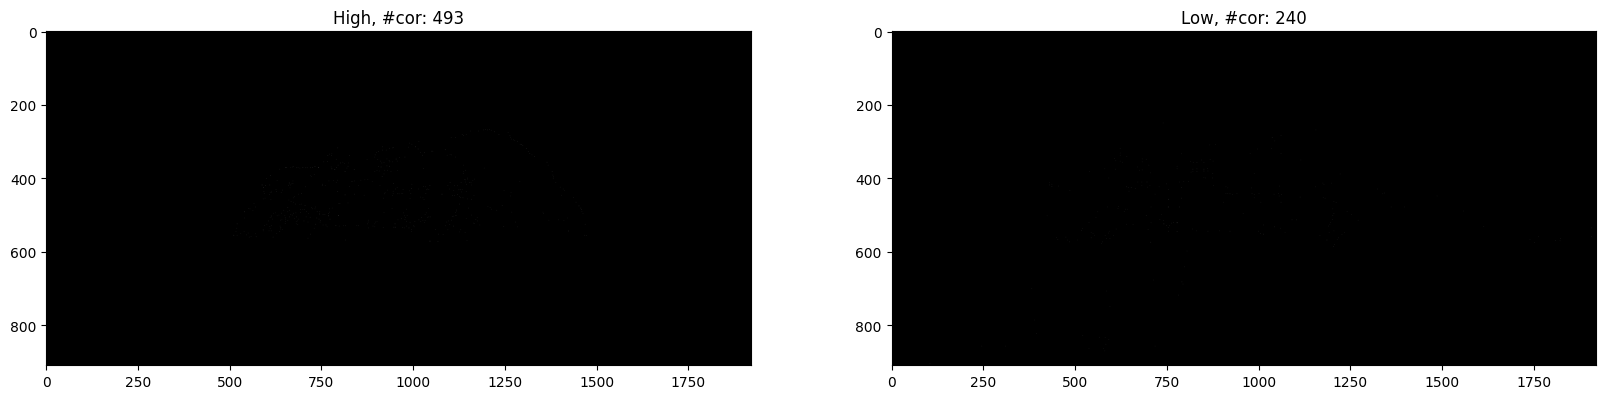

In [137]:

# iterate over the scales and plot the corners
# fig, axes = plt.subplots(2, scales, figsize=(20, 7))
# for i in range(scales):
#     # Plot corners for high
#     axes[0, i].imshow(corners_arr_high[i], cmap='gray')
#     axes[0, i].set_title(f"Scale {i} (High), #cor: {np.sum(corners_arr_high[i] != 0)}")
#     # Plot corners for low
#     axes[1, i].imshow(corners_arr_low[i], cmap='gray')
#     axes[1, i].set_title(f"Scale {i} (Low), #cor: {np.sum(corners_arr_low[i] != 0)}")
# 
# plt.show()

# 
# plot the corners for the first scale for the low and high images next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
axes[0].imshow(corners_arr_high[0], cmap='gray')
axes[0].set_title(f"High, #cor: {np.sum(corners_arr_high[0] != 0)}")
axes[1].imshow(corners_arr_low[0], cmap='gray')
axes[1].set_title(f"Low, #cor: {np.sum(corners_arr_low[0] != 0)}")
plt.show()

In [145]:
descriptors_low = get_mops_descriptors(low_pyramid, corners_arr_low, descriptor_window_size, scale_added_to_get_descriptor)
descriptors_high = get_mops_descriptors(high_pyramid, corners_arr_high, descriptor_window_size, scale_added_to_get_descriptor)


1


In [146]:
def wavelet_transform(image, wavelet='haar'):
    # Perform 2D Discrete Wavelet Transform
    coeffs = pywt.dwt2(image, wavelet)
    return coeffs
    

# create a function that returns the best matches for each descriptor
def get_all_matches(descriptors1, descriptors2):
    matches = []
    descriptors1_wavelets = np.array([wavelet_transform(d[4]) for d in descriptors1])
    descriptors2_wavelets = np.array([wavelet_transform(d[4]) for d in descriptors2])
    for i, d in enumerate(descriptors1_wavelets):
        best_match_idx, second_best_match_idx, NN_1, NN_2  = get_best_match(d, descriptors2_wavelets)
        best_match = descriptors2[best_match_idx]
        second_best_match = descriptors2[second_best_match_idx]
        # if best_match is not None and second_best_match is not None:
            # if not NN_1 or not NN_2 or NN_2 == 0:
            #     continue
        matches.append([d, best_match, NN_1 / NN_2])
        if i % 500 == 0:
            print(f'iteration {i}') 
    matches.sort(key=lambda x: x[2])
    return matches

all_matches = get_all_matches(descriptors_high, descriptors_low)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (493, 2) + inhomogeneous part.

[431,
 972,
 0,
 1.9543238427518885,
 array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])]

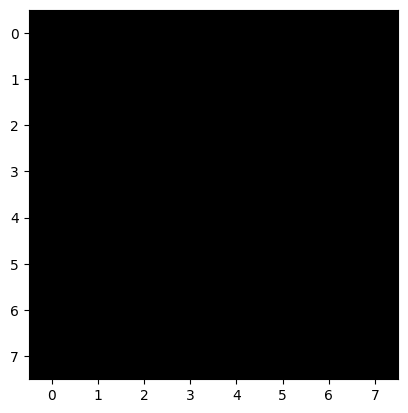

In [83]:
plt.imshow(d, cmap='gray')

In [359]:
matches_ratio_threshold = 1
matches = get_best_matches(all_matches, matches_ratio_threshold)

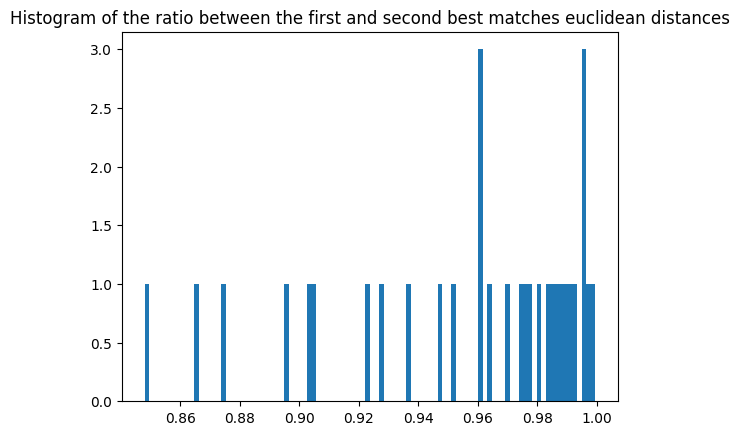

In [360]:
# plot histogram of the ratio between the first and second best matches euclidean distances
ratios = [match[2] for match in matches]
plt.hist(ratios, bins=100)
plt.title('Histogram of the ratio between the first and second best matches euclidean distances')
plt.show()


In [261]:
matches_with_original_coordinates = get_matches_with_original_coordinates(matches)

best_H, inliers = ransac(matches_with_original_coordinates, 1000, 10)

transformed_img = transform_image(img_high_res, best_H)
# create a mask that is 1 in the area of the transformed image and 0 in the area of the original image
mask = np.any(transformed_img != 0, axis=-1).astype(int)

blended_img = deepcopy(img_low_res)
blended_img[mask == 1] = transformed_img[mask == 1]


iteration 0, best inliers: 11
iteration 100, best inliers: 27
iteration 200, best inliers: 28
iteration 300, best inliers: 28
iteration 400, best inliers: 28
iteration 500, best inliers: 30
iteration 600, best inliers: 31
iteration 700, best inliers: 31
iteration 800, best inliers: 31
iteration 900, best inliers: 31


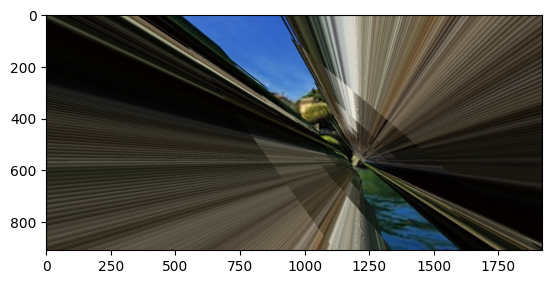

In [262]:
plt.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))

first match descriptor: 560 571 0 -0.9768236449227915
second match descriptor: 443 907 0 -0.9994588469612699


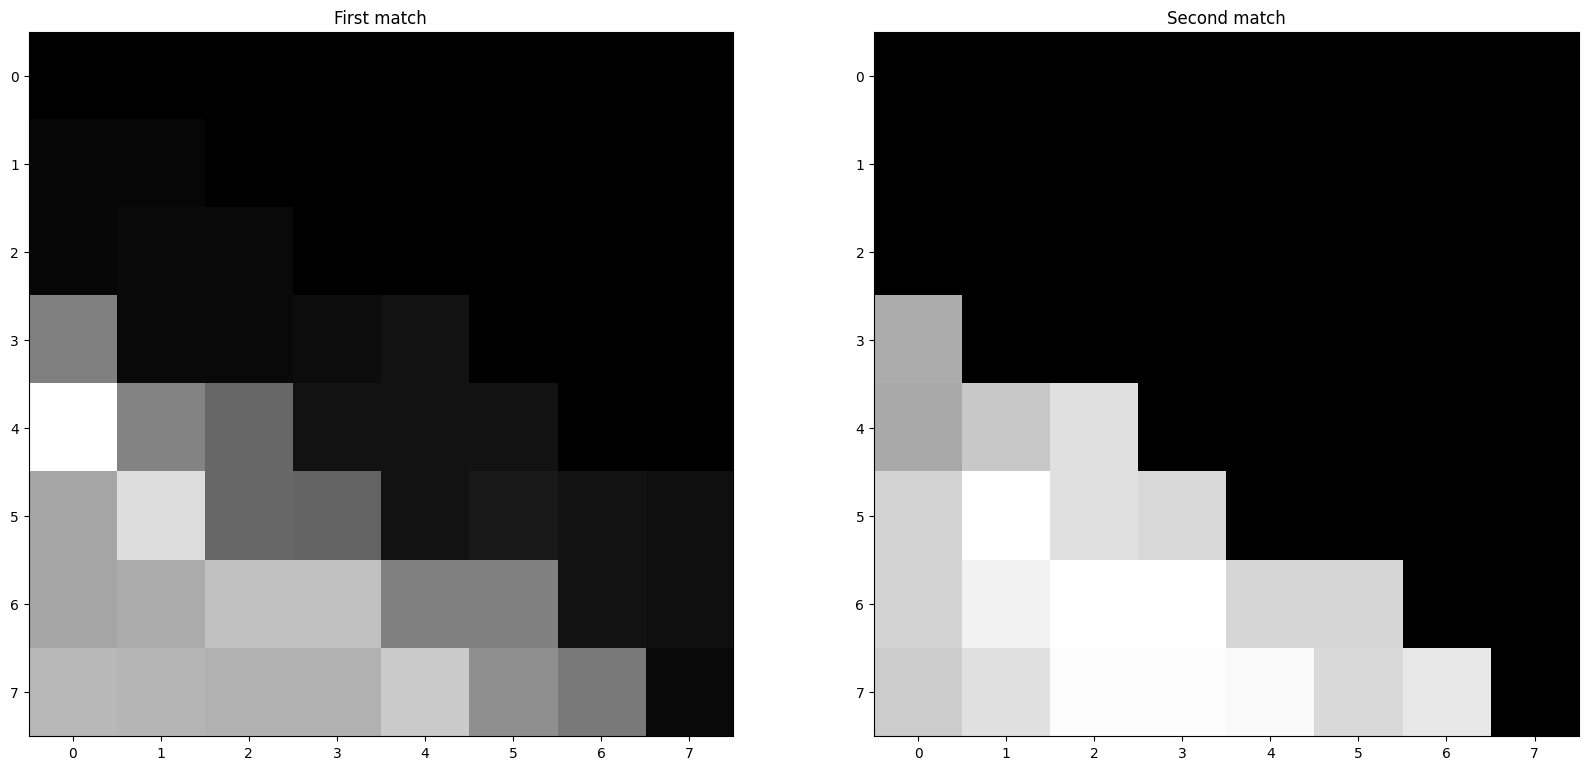

In [279]:
# plot the matches for i index in the matches list and print the descriptors of the first match
i = 2
print('first match descriptor:', matches[i][0][0], matches[i][0][1], matches[i][0][2], matches[i][0][3])
print('second match descriptor:', matches[i][1][0], matches[i][1][1], matches[i][1][2], matches[i][1][3])
# plot the matches next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(matches[i][0][4], cmap='gray')
axes[0].set_title('First match')
axes[1].imshow(matches[i][1][4], cmap='gray')
axes[1].set_title('Second match')
plt.show()




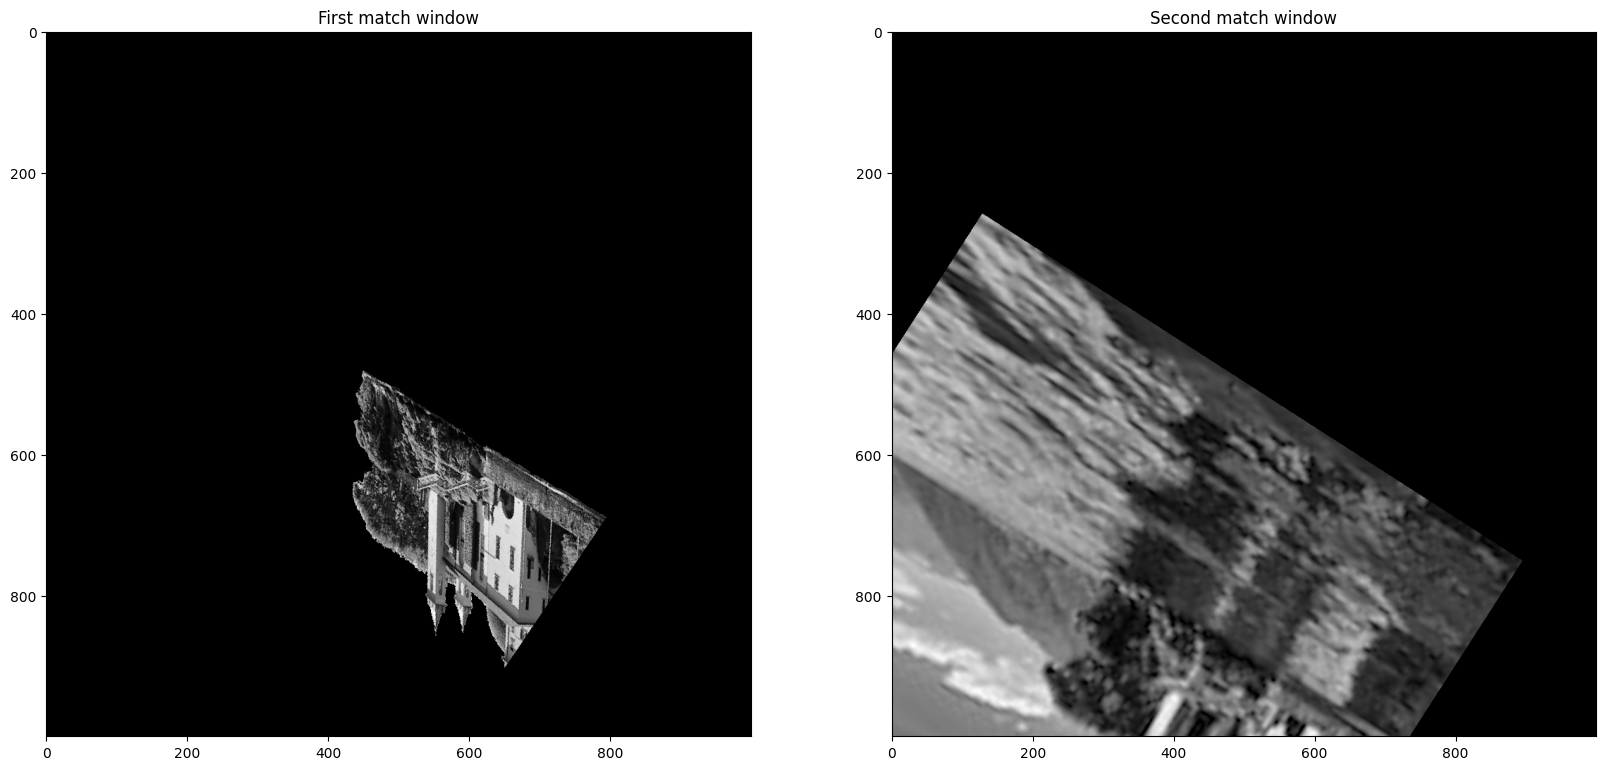

In [281]:
# show windows of the first match for each corner by using the x, y, scale and theta of the first match (show the windows next to each other)
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
x, y, scale, theta, descriptor = matches[i][0]
window = backward_warping_window(x, y, theta, high_pyramid[scale]['G'], 1000)
axes[0].imshow(window, cmap='gray')
axes[0].set_title('First match window')
x, y, scale, theta, descriptor = matches[i][1]
window = backward_warping_window(x, y, theta, low_pyramid[scale]['G'], 1000)
axes[1].imshow(window, cmap='gray')
axes[1].set_title('Second match window')
plt.show()


iteration 0, best inliers: 16
iteration 100, best inliers: 30
iteration 200, best inliers: 36
iteration 300, best inliers: 37
iteration 400, best inliers: 41
iteration 500, best inliers: 41
iteration 600, best inliers: 41
iteration 700, best inliers: 41
iteration 800, best inliers: 41
iteration 900, best inliers: 41
iteration 1000, best inliers: 46
iteration 1100, best inliers: 46
iteration 1200, best inliers: 46
iteration 1300, best inliers: 46
iteration 1400, best inliers: 51
iteration 1500, best inliers: 51
iteration 1600, best inliers: 51
iteration 1700, best inliers: 51
iteration 1800, best inliers: 51
iteration 1900, best inliers: 51
iteration 2000, best inliers: 51
iteration 2100, best inliers: 51
iteration 2200, best inliers: 51
iteration 2300, best inliers: 51
iteration 2400, best inliers: 51
iteration 2500, best inliers: 51
iteration 2600, best inliers: 51
iteration 2700, best inliers: 51
iteration 2800, best inliers: 51
iteration 2900, best inliers: 51
iteration 3000, best i

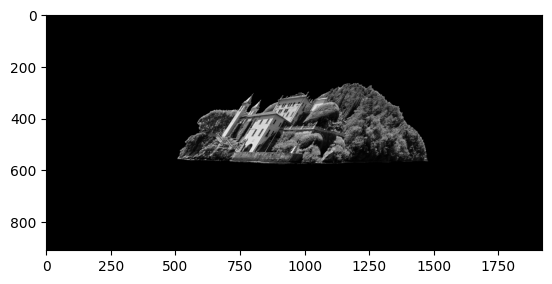

In [286]:
plt.imshow(img_high_res_gray, cmap='gray')

(910, 1920)


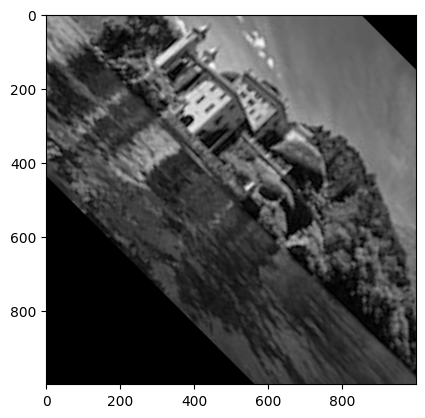

In [130]:



print(img_low_res_gray.shape)
theta = np.pi * 0.25
window = backward_warping_window(600, 1000, theta, img_low_res_gray, 1000)
plt.imshow(window, cmap='gray')

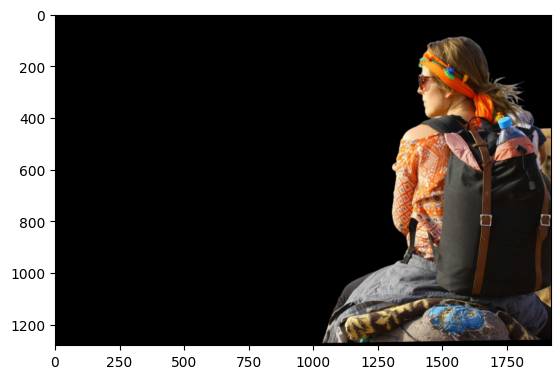

In [698]:
plt.imshow(cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))


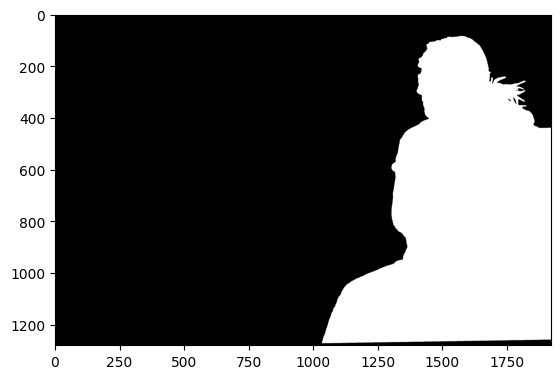

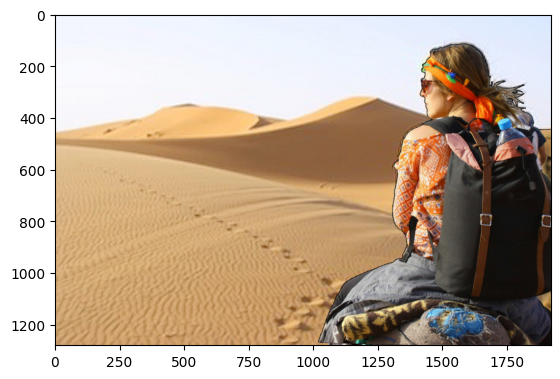

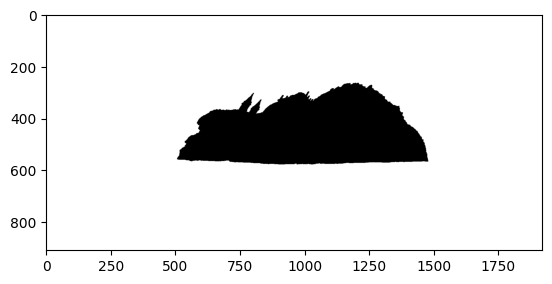

In [324]:

mask = create_mask_of_background(img_high_res_gray)
plt.imshow(mask, cmap='gray')